In [17]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml
from liftoff import parse_opts
from argparse import Namespace
from experiment_src import *
import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("."))))
sys.path.append(root_dir)

from experiment_src import (
    train_net_with_value_function_approximation,
    generate_random_policy_transitions,
    generate_transitions_observations
)
from experiments.experiment_utils import setup_logger, seed_everything
from overfitting.src.policy_iteration import random_policy_evaluation_q_stochastic
from overfitting.src.utils import (
    create_random_policy,
    extract_V_from_Q_for_stochastic_policy,
)
from overfitting.src.visualize import draw_simple_gridworld
from experiment_src import generate_train_test_split_with_valid_path, check_path_existence_to_any_terminal

import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def count_occurrences_and_compute_percentage(
    sampled_transitions_list, total_unique_transitions, N
):
    # Count occurrences of each index in the sampled list
    occurrences_count = {}
    for index in sampled_transitions_list:
        occurrences_count[index] = occurrences_count.get(index, 0) + 1

    # Compute the number of indexes that appear at least N times
    at_least_N = sum(1 for count in occurrences_count.values() if count >= N)

    # Compute the percentage relative to the total number of unique transitions
    percentage = (at_least_N / total_unique_transitions) * 100
    return percentage, occurrences_count

In [19]:
nr_samples = 40_000
transitions = [i for i in range(400)]
tau = 0.001
minimum_samples = 50
# minimum_samples =  nr_samples / len(transitions)

# logits = np.random.uniform(0, 1, size=len(transitions))
# prob_dist = softmax(logits, tau, minimum_samples)
# prob_dist

res = generate_transitions_observations(transitions, nr_samples, tau, minimum_samples)

# Now, let's count the occurrences and compute the percentage for N=2
N = 50
percentage, occurrences = count_occurrences_and_compute_percentage(
    res, len(transitions), N
)
print(f"Percentage of indexes that show up at least {N} times: {percentage}%")
print("Occurrences:", occurrences)

Percentage of indexes that show up at least 50 times: 100.0%
Occurrences: {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50, 40: 50, 41: 50, 42: 50, 43: 50, 44: 50, 45: 50, 46: 50, 47: 50, 48: 50, 49: 50, 50: 50, 51: 50, 52: 50, 53: 50, 54: 50, 55: 50, 56: 50, 57: 50, 58: 50, 59: 50, 60: 50, 61: 50, 62: 50, 63: 50, 64: 50, 65: 160, 66: 50, 67: 50, 68: 50, 69: 50, 70: 50, 71: 50, 72: 50, 73: 50, 74: 50, 75: 50, 76: 50, 77: 50, 78: 50, 79: 50, 80: 50, 81: 50, 82: 50, 83: 50, 84: 50, 85: 50, 86: 50, 87: 50, 88: 50, 89: 50, 90: 50, 91: 50, 92: 50, 93: 50, 94: 50, 95: 50, 96: 50, 97: 50, 98: 50, 99: 50, 100: 50, 101: 50, 102: 50, 103: 50, 104: 50, 105: 5098, 106: 50, 107: 50, 108: 50, 109: 50, 110: 50, 111: 50, 112: 50, 113: 50, 114: 5

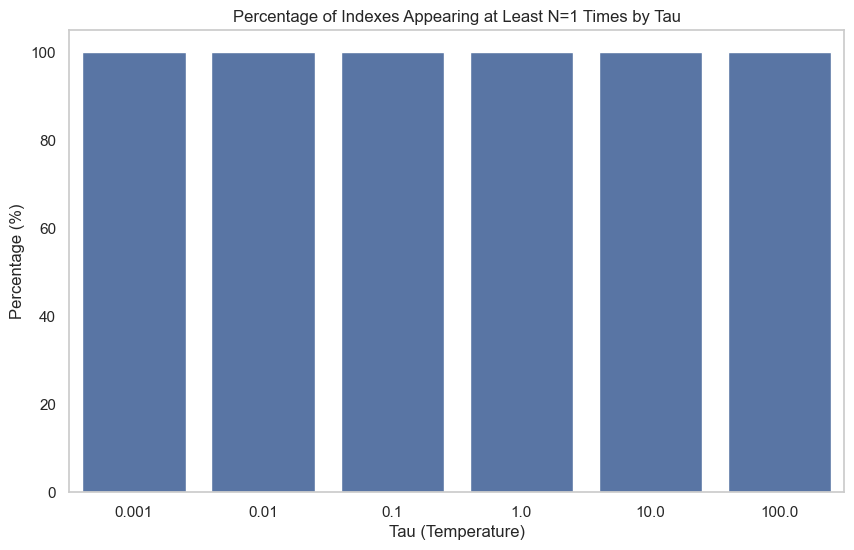

In [20]:
taus = [0.001, 0.01, 0.1, 1, 10, 100]
N = 1

# Results storage
tau_percentages = []

# Experiment
for tau in taus:
    res = generate_transitions_observations(
        transitions, nr_samples, tau, minimum_samples
    )
    percentage, occurrences = count_occurrences_and_compute_percentage(
        res, len(transitions), N
    )
    tau_percentages.append((tau, percentage))

tau_percentages

tau_percentage_df = pd.DataFrame(tau_percentages, columns=["Tau", "Percentage"])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Tau", y="Percentage", data=tau_percentage_df)
plt.title(f"Percentage of Indexes Appearing at Least N={N} Times by Tau")
plt.xlabel("Tau (Temperature)")
plt.ylabel("Percentage (%)")
plt.show()

In [23]:
40_000 / 320

125.0

In [25]:
125/20

6.25

In [ ]:
# TODO: complete sanity check for adjusted loss
# TODO: rerun experiment with variable tau, fixed min samples (max 20 here)
# TODO: rerun experiment with fixed tau and varaible min samples

In [27]:
logits = np.random.uniform(0, 1, size=400)
prob_dist = softmax(logits, 0.001)
prob_dist

array([4.52595214e-220, 3.50237875e-156, 3.58623464e-035, 4.22670915e-150,
       2.17091464e-281, 1.70370057e-315, 1.75893036e-252, 1.05732059e-139,
       4.87397891e-077, 0.00000000e+000, 6.81958811e-320, 0.00000000e+000,
       8.90080819e-229, 0.00000000e+000, 1.45799193e-124, 3.65896059e-312,
       0.00000000e+000, 0.00000000e+000, 5.22085440e-292, 1.00794373e-102,
       3.54488089e-169, 3.39684353e-229, 4.77200836e-299, 5.72244222e-042,
       2.63672381e-263, 4.09411293e-202, 3.15574685e-007, 1.79412791e-076,
       3.35174998e-004, 5.71764675e-307, 0.00000000e+000, 5.00437001e-030,
       2.30342684e-025, 0.00000000e+000, 1.18689197e-272, 1.12004682e-320,
       5.01259353e-114, 8.61168772e-318, 2.15096982e-189, 6.83839075e-212,
       6.30179642e-243, 2.63809356e-248, 9.63378405e-159, 4.94690154e-163,
       7.31355864e-091, 2.71179571e-140, 1.23901206e-041, 1.49204678e-019,
       0.00000000e+000, 0.00000000e+000, 2.61741850e-123, 3.28554664e-301,
       1.56785259e-234, 0

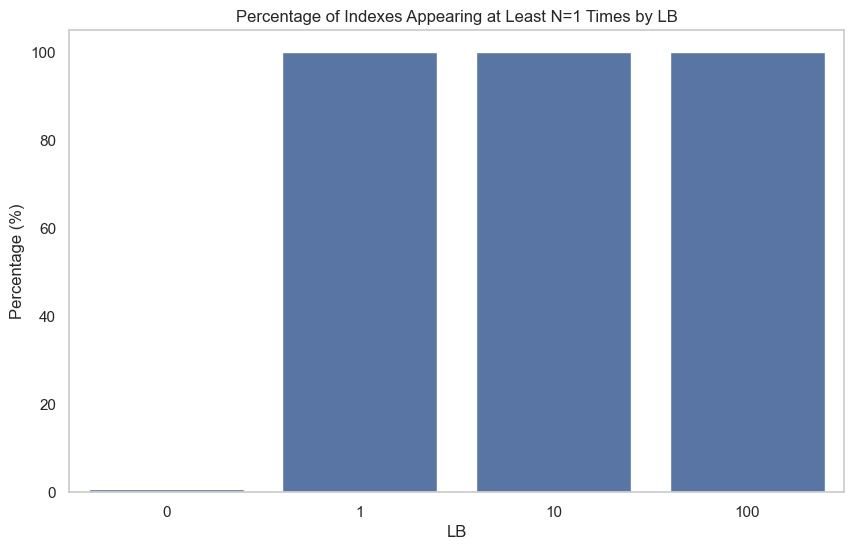

In [22]:
tau = 0.001
N = 1
minimum_samples = [0, 1, 10, 100]

# minimum_samples = 1 / len(transitions)


# Results storage
ms_percentages = []

# Experiment
for ms in minimum_samples:
    res = generate_transitions_observations(transitions, nr_samples, tau, ms)
    percentage, occurrences = count_occurrences_and_compute_percentage(
        res, len(transitions), N
    )
    ms_percentages.append((ms, percentage))

lb_percentage_df = pd.DataFrame(ms_percentages, columns=["LowerBound", "Percentage"])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="LowerBound", y="Percentage", data=lb_percentage_df)
plt.title(f"Percentage of Indexes Appearing at Least N={N} Times by LB")
plt.xlabel("LB")
plt.ylabel("Percentage (%)")
plt.show()

In [7]:
def estimate_V_optimal_from_net(net, states):
    V_net_estimated = {}
    net.eval()  # Ensure the network is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        for state in states:
            state_tensor = torch.tensor([state], dtype=torch.float)
            action_values = net(state_tensor)
            max_action_value = torch.max(action_values).item()
            V_net_estimated[state] = max_action_value
    return V_net_estimated


# Mean instead of max
def estimate_V_pi_from_net(net, states):
    V_net_estimated = {}
    net.eval()  # Ensure the network is in evaluation mode
    with torch.no_grad():  # Disable gradient computation for efficiency
        for state in states:
            state_tensor = torch.tensor([state], dtype=torch.float)
            action_values = net(state_tensor)
            mean_action_value = torch.mean(action_values).item()
            V_net_estimated[state] = mean_action_value
    return V_net_estimated


def compare_value_functions(V1, V2, states):
    mse = sum((V1[state] - V2[state]) ** 2 for state in states) / len(states)
    return mse


def plot_state_counts_heatmap(transitions, title="State Counts"):
    # Convert dataset to DataFrame
    columns = ["state", "action", "next_state", "reward", "done", "prob"]
    df = pd.DataFrame(transitions, columns=columns)

    # Split state and next_state into separate columns for rows and cols
    df[["state_row", "state_col"]] = pd.DataFrame(df["state"].tolist(), index=df.index)
    df[["next_state_row", "next_state_col"]] = pd.DataFrame(
        df["next_state"].tolist(), index=df.index
    )

    # Group by state positions to count occurrences
    train_state_counts = (
        df.groupby(["state_row", "state_col"]).size().reset_index(name="counts")
    )

    # Pivot the counts data for heatmap plotting
    train_state_heatmap = train_state_counts.pivot(
        index="state_row", columns="state_col", values="counts"
    )

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.xlabel("State Column")
    plt.ylabel("State Row")
    plt.show()

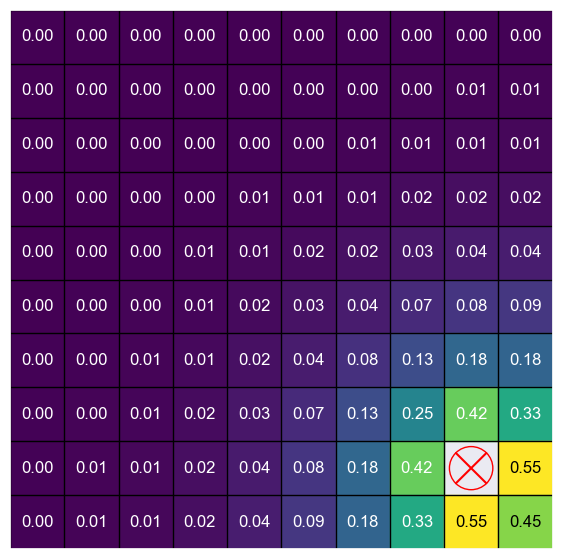

In [105]:
# Env settings
rows, cols = 10, 10
start_state = (0, 0)
terminal_states = {(rows - 2, cols - 2): 1.0}
p_success = 1
seed = 3

num_steps = 40_000
min_samples = 20
# min_samples = 0

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.05  # Convergence criterion
tau = 100
batch_size = 32
train_max_iterations = 50
theta = 1e-6

np.random.seed(seed)

logger = logging.getLogger(__name__)

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))

random_policy = create_random_policy(states, actions)

Q = {state: {action: 0 for action in actions} for state in states}
Q = random_policy_evaluation_q_stochastic(
    states, actions, random_policy, Q, env.mdp, gamma=gamma, theta=theta
)

# Extract the state-value function V from the Q-function
V_random_policy = extract_V_from_Q_for_stochastic_policy(Q, random_policy, states)
# print(V_random_policy)

# keys = list(env.mdp.keys())
# len(keys)

draw_simple_gridworld(
    (rows, cols),
    [],
    V_random_policy,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

In [6]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)

random_policy_transitions = generate_random_policy_transitions(
    transitions_list, num_steps, env, actions, seed, logger
)


### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

qnet_random_policy = QNET(input_size, output_size)

loss_record_random_policy = train_net_with_value_function_approximation(
    qnet_random_policy,
    random_policy_transitions,
    states,
    actions,
    gamma,
    epsilon,
    batch_size,
    train_max_iterations,
    logger,
)

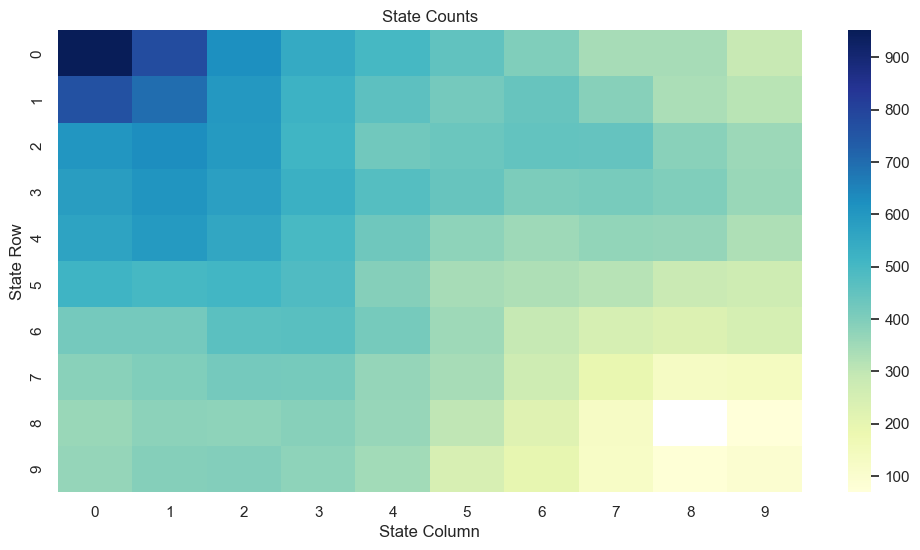

Mean Squared Error between V_random_policy and V_net_estimated: 0.0003886991256992309


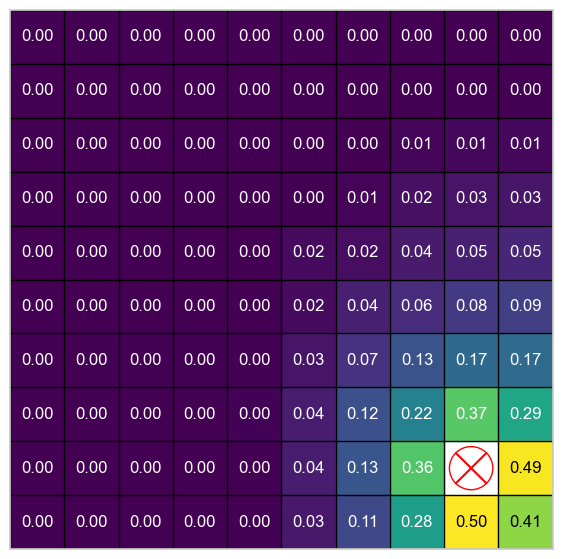

In [7]:
plot_state_counts_heatmap(random_policy_transitions, title="State Counts")

V_net_estimated = estimate_V_pi_from_net(qnet_random_policy, states)

# Assuming V_net_estimated is obtained from estimate_V_from_DQN
mse = compare_value_functions(V_random_policy, V_net_estimated, states)
print(f"Mean Squared Error between V_random_policy and V_net_estimated: {mse}")

draw_simple_gridworld(
    (rows, cols),
    [],
    V_net_estimated,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

In [26]:
tau = 1000
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)

random_policy_transitions = generate_transitions_observations(
    transitions_list,
    num_steps,
    tau=tau,
    minimum_samples=min_samples,
)


### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
qnet_random_policy = QNET(input_size, output_size)

# loss_record_random_policy = train_net_with_value_function_approximation(
#     qnet_random_policy,
#     random_policy_transitions,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size,
#     train_max_iterations,
#     logger,
# )

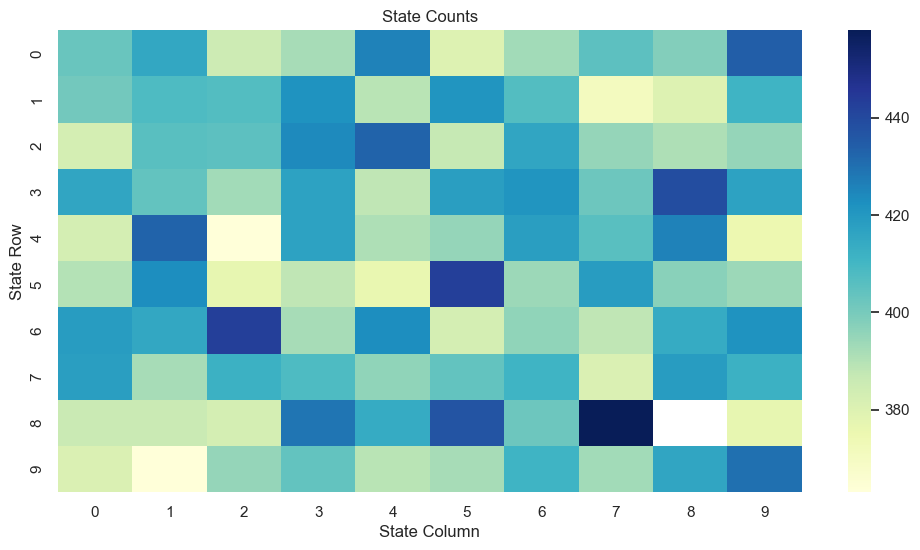

Mean Squared Error between V_random_policy and V_net_estimated: 0.013371009459994062


In [27]:
plot_state_counts_heatmap(random_policy_transitions, title="State Counts")

V_net_estimated = estimate_V_pi_from_net(qnet_random_policy, states)

# Assuming V_net_estimated is obtained from estimate_V_from_DQN
mse = compare_value_functions(V_random_policy, V_net_estimated, states)
print(f"Mean Squared Error between V_random_policy and V_net_estimated: {mse}")

# draw_simple_gridworld(
#     (rows, cols),
#     [],
#     V_net_estimated,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

In [ ]:
tau = 0.01
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)

random_policy_transitions = generate_transitions_observations(
    transitions_list,
    num_steps,
    tau=tau,
    minimum_samples=min_samples / len(transitions_list),
)


### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
qnet_random_policy = QNET(input_size, output_size)

loss_record_random_policy = train_net_with_value_function_approximation(
    qnet_random_policy,
    random_policy_transitions,
    states,
    actions,
    gamma,
    epsilon,
    batch_size,
    train_max_iterations,
    logger,
)

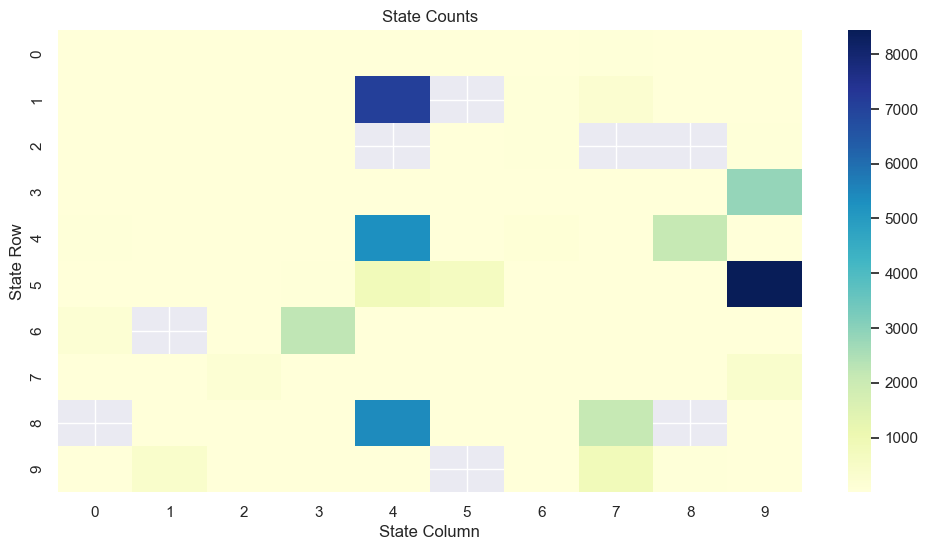

Mean Squared Error between V_random_policy and V_net_estimated: 0.0186996906665038


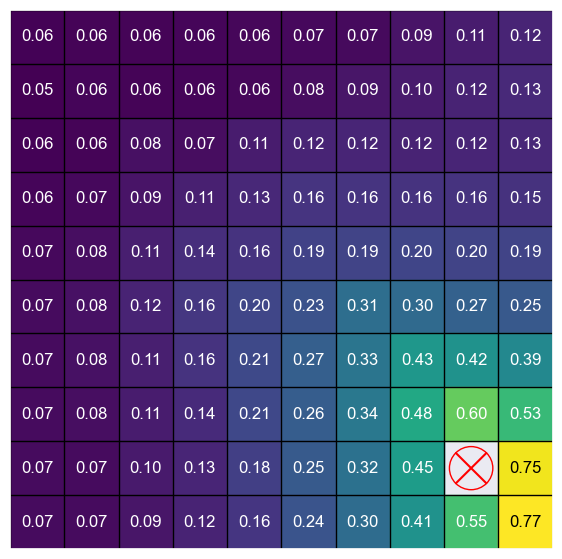

In [ ]:
plot_state_counts_heatmap(random_policy_transitions, title="State Counts")

V_net_estimated = estimate_V_pi_from_net(qnet_random_policy, states)

# Assuming V_net_estimated is obtained from estimate_V_from_DQN
mse = compare_value_functions(V_random_policy, V_net_estimated, states)
print(f"Mean Squared Error between V_random_policy and V_net_estimated: {mse}")

draw_simple_gridworld(
    (rows, cols),
    [],
    V_net_estimated,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

In [174]:
# TODO: implement check that you can make at least one path between start and terminal state


def build_graph_with_networkx(transitions, start_state, terminal_states):
    G = nx.DiGraph()  # Directed graph
    # Explicitly add the start state as a node
    G.add_node(start_state)
    # Also add each terminal state as a node
    for terminal_state in terminal_states.keys():
        G.add_node(terminal_state)
    for current_state, action, next_state, reward, done, prob in transitions:
        G.add_edge(current_state, next_state)
    return G


def check_path_existence_to_any_terminal(G, start_state, terminal_states):
    for terminal_state in terminal_states.keys():
        if nx.has_path(G, start_state, terminal_state):
            return True
    return False


start_state = (0, 0)
terminal_states = {(rows - 1, cols - 1): 1.0, (0, cols - 1): 1.0}

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]


found = False
attempts = 0
max_attempts = 100

while not found and attempts < max_attempts:
    transitions_train, transitions_val = train_test_split(
        transitions_list, test_size=0.2, random_state=np.random.randint(0, 10000)
    )
    G = build_graph_with_networkx(transitions_train, start_state, terminal_states)
    if not check_path_existence_to_any_terminal(G, start_state, terminal_states):
        found = True  # A split is found where no path exists
    attempts += 1

print(f"Path does not exist, found a split accordingly after {attempts} iterations.")

Path does not exist, found a split accordingly after 28 iterations.


In [175]:
specific_start_state = (0, 0)

# Filter transitions for the specific next state
filtered_transitions = [
    transition
    for transition in transitions_train
    if transition[0] == specific_start_state
]

print(filtered_transitions)

[((0, 0), <Action.UP: 0>, (0, 0), 0, False, 1), ((0, 0), <Action.LEFT: 3>, (0, 0), 0, False, 1)]


In [176]:
specific_next_state = (0, 9)

# Filter transitions for the specific next state
filtered_transitions = [
    transition
    for transition in transitions_train
    if transition[2] == specific_next_state
]

print(filtered_transitions)

[((1, 9), <Action.UP: 0>, (0, 9), 1.0, True, 1)]


In [177]:
specific_next_state = (9, 9)

# Filter transitions for the specific next state
filtered_transitions = [
    transition
    for transition in transitions_train
    if transition[2] == specific_next_state
]

print(filtered_transitions)

[((9, 8), <Action.RIGHT: 1>, (9, 9), 1.0, True, 1), ((8, 9), <Action.DOWN: 2>, (9, 9), 1.0, True, 1)]


In [179]:
### Rerunning experiment

rows, cols = 10, 10
start_state = (1, 1)
terminal_states = {(8, 8): 1.0}
seed = 614245669

gamma = 0.9
epsilon = 0.01
num_steps = 40_000
tau = 0.001
min_samples = 0.5
batch_size = 32
train_max_iterations = 300

In [184]:
seed_everything(seed)

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))
random_policy = create_random_policy(states, actions)

Q = {state: {action: 0 for action in actions} for state in states}
Q_pi_random = random_policy_evaluation_q_stochastic(
    states, actions, random_policy, Q, env.mdp, gamma, epsilon
)

transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = generate_train_test_split_with_valid_path(
    transitions_list=transitions_list,
    start_state=start_state,
    terminal_states=terminal_states,
)
sampled_transitions_train = generate_transitions_observations(
    transitions_train,
    num_steps,
    tau=tau,
    minimum_samples=min_samples / len(transitions_train),
)

In [187]:
G = build_graph_with_networkx(transitions_train, start_state, terminal_states)
check_path_existence_to_any_terminal(G, start_state, terminal_states)

True

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_1284\89503345.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 4)  # 4 distinct colors for different states


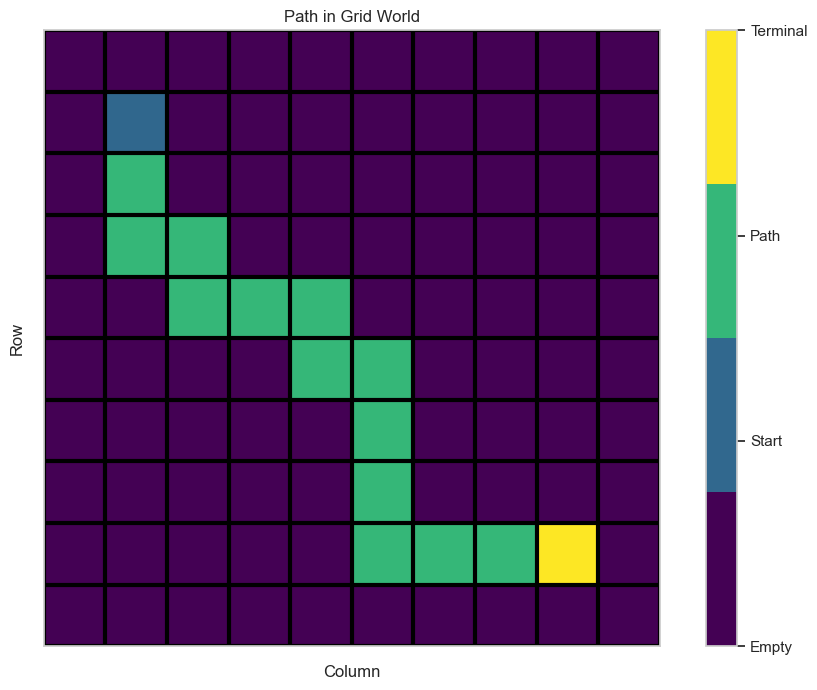

In [206]:
def plot_grid_path(rows, cols, path_transitions, title="Path in Grid World"):
    # Initialize a matrix to represent the grid
    grid = np.zeros((rows, cols))

    # Mark the start, terminal, and path states in the grid
    for i, (current_state, action, next_state, reward, done, p) in enumerate(
        path_transitions
    ):
        # Mark the current state. If it's the first one, mark it differently to represent the start state
        grid[current_state] = 1 if i == 0 else 2
        if done:
            # If the next state is a terminal state, mark it differently
            grid[next_state] = 3

    # Create a color map for visual distinction
    cmap = plt.cm.get_cmap("viridis", 4)  # 4 distinct colors for different states

    # Plot the grid as a heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(grid, cmap=cmap, origin="upper")
    plt.colorbar(
        ticks=[0, 1, 2, 3],
        format=plt.FuncFormatter(
            lambda val, loc: ["Empty", "Start", "Path", "Terminal"][loc]
        ),
    )

    # Adjusting the grid lines to be offset from the cells, to appear as walls
    plt.xticks(np.arange(-0.5, cols, 1), minor=True)
    plt.yticks(np.arange(-0.5, rows, 1), minor=True)
    plt.grid(
        which="minor", color="black", linestyle="-", linewidth=3
    )  # Increased linewidth
    plt.tick_params(which="minor", size=0)  # Hide the minor tick marks

    # Remove the labels for major ticks to clean up the plot
    plt.xticks(ticks=np.arange(cols), labels=[""] * cols)
    plt.yticks(ticks=np.arange(rows), labels=[""] * rows)

    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


def find_path_and_plot(G, start_state, terminal_states, transitions_list, rows, cols):
    # Attempt to find a path from start to terminal
    path_found = None
    for terminal in terminal_states:
        if nx.has_path(G, start_state, terminal):
            path_found = nx.shortest_path(G, start_state, terminal)
            break

    if not path_found:
        print("No path found from start to terminal.")
        return

    # Extract transitions corresponding to the found path
    path_transitions = []
    for i in range(len(path_found) - 1):
        for transition in transitions_list:
            if transition[0] == path_found[i] and transition[2] == path_found[i + 1]:
                path_transitions.append(transition)
                break

    # Now call the plotting function with correct dimensions and path transitions
    plot_grid_path(rows, cols, path_transitions)

    return path_transitions


path_transitions = find_path_and_plot(
    G, start_state, terminal_states, transitions_list, rows, cols
)

In [198]:
for t in path_transitions:
    print(t)

((1, 1), <Action.DOWN: 2>, (2, 1), 0, False, 1)
((2, 1), <Action.DOWN: 2>, (3, 1), 0, False, 1)
((3, 1), <Action.RIGHT: 1>, (3, 2), 0, False, 1)
((3, 2), <Action.DOWN: 2>, (4, 2), 0, False, 1)
((4, 2), <Action.RIGHT: 1>, (4, 3), 0, False, 1)
((4, 3), <Action.RIGHT: 1>, (4, 4), 0, False, 1)
((4, 4), <Action.DOWN: 2>, (5, 4), 0, False, 1)
((5, 4), <Action.RIGHT: 1>, (5, 5), 0, False, 1)
((5, 5), <Action.DOWN: 2>, (6, 5), 0, False, 1)
((6, 5), <Action.DOWN: 2>, (7, 5), 0, False, 1)
((7, 5), <Action.DOWN: 2>, (8, 5), 0, False, 1)
((8, 5), <Action.RIGHT: 1>, (8, 6), 0, False, 1)
((8, 6), <Action.RIGHT: 1>, (8, 7), 0, False, 1)
((8, 7), <Action.RIGHT: 1>, (8, 8), 1.0, True, 1)


In [200]:
for t in path_transitions:
    if t not in transitions_list:
        print(t)

In [194]:
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
dqn = QNET(input_size, output_size)

loss_record = train_net_with_neural_fitted_q(
    dqn,
    sampled_transitions_train,
    Q_pi_random,
    states,
    actions,
    gamma,
    epsilon,
    batch_size=batch_size,
    max_iterations=train_max_iterations,
    logger=logger,
)

bm_error = compute_bellmans_error(
    dqn, validation_transitions=transitions_val, gamma=gamma
)

In [195]:
bm_error

306385607065.6

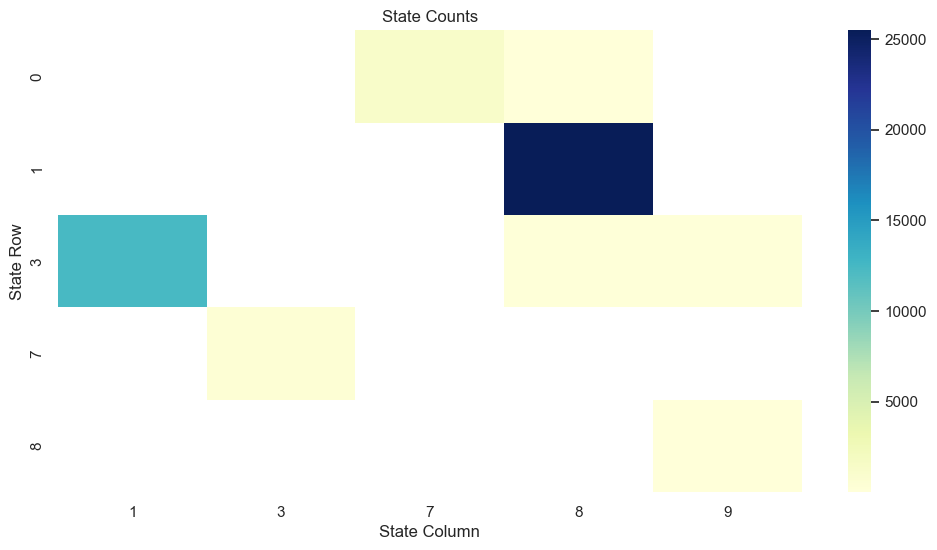

In [11]:
tau = 0.001
min_samples = 0


transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)

minimum_samples = min_samples / len(transitions_list)

# random_policy_transitions = generate_transitions_observations(
#     transitions_list,
#     num_steps,
#     tau=tau,
#     minimum_samples=min_samples / len(transitions_list),
# )

dset_size = len(transitions_list)
logits = np.random.uniform(0, 1, size=dset_size)
# prob_dist = softmax(logits, tau, minimum_samples)

logits = np.array(logits)  # Ensure logits is a NumPy array for consistent operations
logits -= np.max(logits)  # Improves numerical stability
exp_logits = np.exp(logits / tau)
softmax_probs = exp_logits / np.sum(exp_logits)
prob_dist = np.clip(
    softmax_probs + minimum_samples, 0, 1
)  # Ensure probabilities are valid
prob_dist /= np.sum(prob_dist)

sampled_indices = np.random.choice(len(transitions_list), size=num_steps, p=prob_dist)
sampled_transitions = [transitions_list[i] for i in sampled_indices]

plot_state_counts_heatmap(sampled_transitions, title="State Counts")